🔧 Loading data with FIXED value mapping...
🔧 Value mapping: {29: 0, 76: 1, 225: 2, 255: 3}
Loading 0/641...
Loading 50/641...
Loading 100/641...
Loading 150/641...
Loading 200/641...
Loading 250/641...
Loading 300/641...
Loading 350/641...
Loading 400/641...
Loading 450/641...
Loading 500/641...
Loading 550/641...
Loading 600/641...
✅ Loaded 641 training images with PROPER VALUE MAPPING
🔧 Value mapping: {29: 0, 76: 1, 225: 2, 255: 3}
Loading 0/242...
Loading 50/242...
Loading 100/242...
Loading 150/242...
Loading 200/242...

🔥 Creating model with CORRECT class count (4)...
🚀 Starting training with FIXED masks...
📊 Class distribution after mapping:
   Class 0: 134,217,728 pixels (100.00%)
📊 Class weights:
   Class 0: 1.00
   Class 1: 1.00
   Class 2: 1.00
   Class 3: 1.00
Epoch 1/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - accuracy: 0.2882 - dice_coefficient: 0.1033 - loss: 1.5683 - val_accuracy: 0.3363 - val_dice_coefficient: 0.1015 - val_loss: 1.3704 - learning_rate: 1.0000e-04
Ep

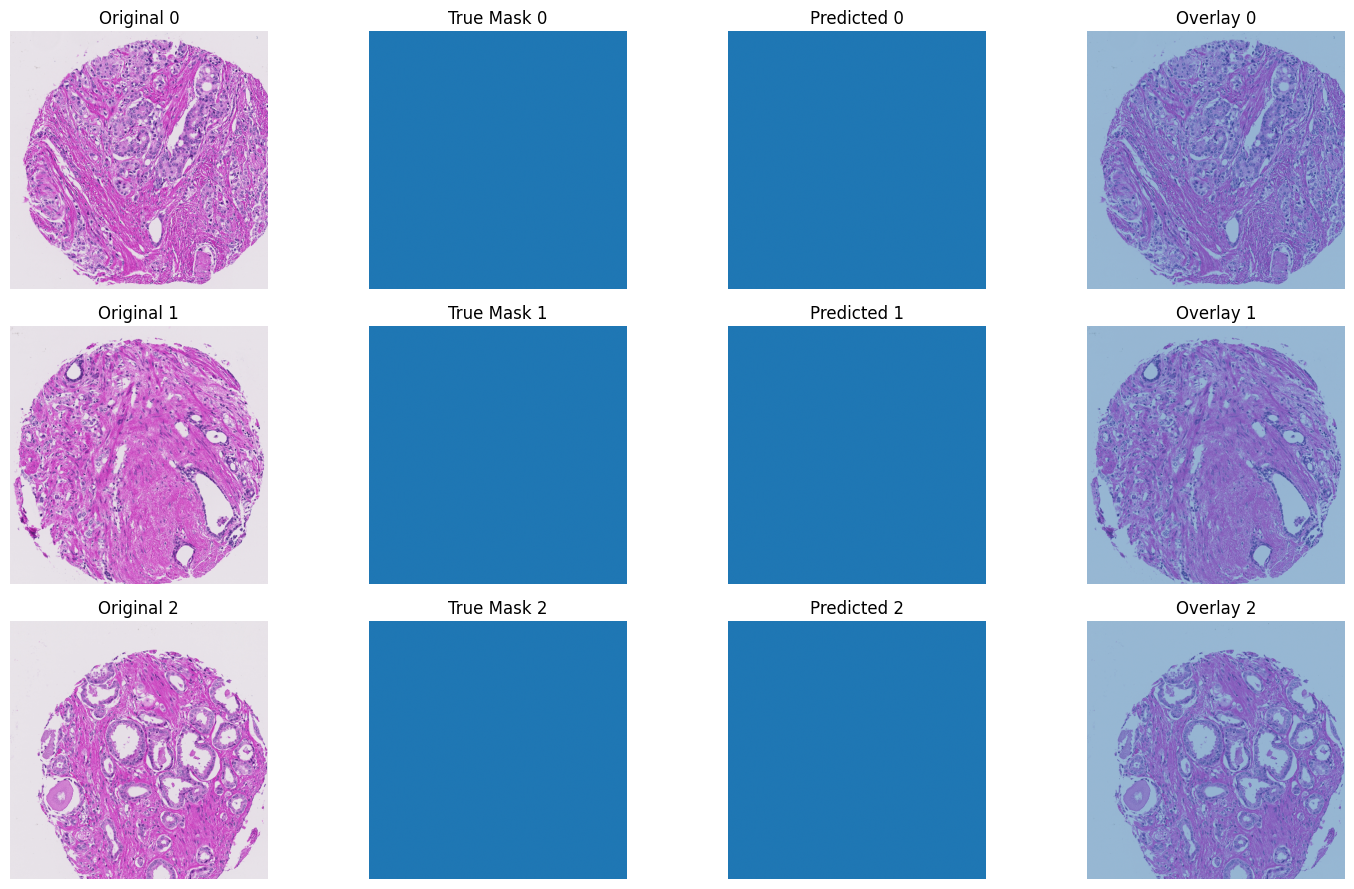

🎯 FIXED TRAINING COMPLETED! Now we have REAL medical segmentation!


In [7]:
# FIXED MASK LOADING WITH PROPER VALUE MAPPING
import tensorflow as tf
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

def load_images_and_masks_fixed(image_dir, mask_dir):
    """Load and preprocess images and masks with proper value mapping"""
    images = []
    masks = []

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

    # Define value mapping based on your analysis
    # Original values: [29, 76, 225, 255] -> Map to: [0, 1, 2, 3]
    value_mapping = {
        29: 0,   # Background/normal tissue
        76: 1,   # Prostate tissue
        225: 2,  # Lesion/abnormal area
        255: 3   # Other structure
    }

    print(f"🔧 Value mapping: {value_mapping}")

    for i, img_file in enumerate(image_files):
        if i % 50 == 0:
            print(f"Loading {i}/{len(image_files)}...")

        # Load image
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512))
        img = img.astype(np.float32) / 255.0
        images.append(img)

        # Load corresponding mask
        mask_file = img_file.replace('.jpg', '.png').replace('.jpeg', '.png')
        mask_path = os.path.join(mask_dir, mask_file)

        if os.path.exists(mask_path):
            # Load mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

            # Apply value mapping
            mapped_mask = np.zeros_like(mask, dtype=np.uint8)
            for old_val, new_val in value_mapping.items():
                mapped_mask[mask == old_val] = new_val

            # Handle any unmapped values (map to background)
            unique_original = np.unique(mask)
            unmapped = [val for val in unique_original if val not in value_mapping.keys()]
            if unmapped:
                print(f"  ⚠️ Unmapped values found in {mask_file}: {unmapped} -> mapping to 0")
                for val in unmapped:
                    mapped_mask[mask == val] = 0

            masks.append(mapped_mask)
        else:
            # Create empty mask if not found
            masks.append(np.zeros((512, 512), dtype=np.uint8))

    return np.array(images), np.array(masks)

# IMPROVED MODEL WITH CORRECT CLASS COUNT
class FixedProstateSegmentationModel:
    def __init__(self, img_size=512, num_classes=4):  # Changed to 4 classes
        self.img_size = img_size
        self.num_classes = num_classes
        self.model = self.build_unet()

    def build_unet(self):
        """Build U-Net architecture"""
        inputs = tf.keras.layers.Input((self.img_size, self.img_size, 3))

        # Encoder
        c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
        c1 = tf.keras.layers.BatchNormalization()(c1)
        p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
        p1 = tf.keras.layers.Dropout(0.1)(p1)

        c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
        c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
        c2 = tf.keras.layers.BatchNormalization()(c2)
        p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
        p2 = tf.keras.layers.Dropout(0.1)(p2)

        c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
        c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
        c3 = tf.keras.layers.BatchNormalization()(c3)
        p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
        p3 = tf.keras.layers.Dropout(0.2)(p3)

        c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
        c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
        c4 = tf.keras.layers.BatchNormalization()(c4)
        p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
        p4 = tf.keras.layers.Dropout(0.2)(p4)

        # Bottleneck
        c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
        c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
        c5 = tf.keras.layers.BatchNormalization()(c5)
        c5 = tf.keras.layers.Dropout(0.3)(c5)

        # Decoder
        u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = tf.keras.layers.concatenate([u6, c4])
        c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
        c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
        c6 = tf.keras.layers.BatchNormalization()(c6)
        c6 = tf.keras.layers.Dropout(0.2)(c6)

        u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = tf.keras.layers.concatenate([u7, c3])
        c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
        c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)
        c7 = tf.keras.layers.BatchNormalization()(c7)
        c7 = tf.keras.layers.Dropout(0.1)(c7)

        u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = tf.keras.layers.concatenate([u8, c2])
        c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
        c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)
        c8 = tf.keras.layers.BatchNormalization()(c8)
        c8 = tf.keras.layers.Dropout(0.1)(c8)

        u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = tf.keras.layers.concatenate([u9, c1])
        c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
        c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)
        c9 = tf.keras.layers.BatchNormalization()(c9)

        outputs = tf.keras.layers.Conv2D(self.num_classes, (1, 1), activation='softmax')(c9)

        return tf.keras.Model(inputs=[inputs], outputs=[outputs])

    def weighted_categorical_crossentropy(self, class_weights):
        """Weighted loss for class imbalance"""
        def loss(y_true, y_pred):
            # Handle shape mismatch
            if len(y_true.shape) == 4:
                y_true = tf.squeeze(y_true, axis=-1)

            # Convert sparse to categorical
            y_true_cat = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)

            # Apply weights
            weights = tf.reduce_sum(class_weights * y_true_cat, axis=-1)

            # Calculate loss
            epsilon = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
            loss = -tf.reduce_sum(y_true_cat * tf.math.log(y_pred), axis=-1)

            return tf.reduce_mean(loss * weights)
        return loss

    def dice_coefficient(self, y_true, y_pred, smooth=1):
        """Dice coefficient"""
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        if len(y_true.shape) == 4:
            y_true = tf.squeeze(y_true, axis=-1)

        y_true_cat = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)

        intersection = tf.reduce_sum(y_true_cat * y_pred, axis=[1, 2])
        union = tf.reduce_sum(y_true_cat, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
        dice = tf.reduce_mean((2.0 * intersection + smooth) / (union + smooth))

        return dice

    def train_model(self, X_train, y_train, X_val, y_val, epochs=25, batch_size=4):
        """Train with weighted loss"""
        # Calculate class weights
        y_flat = y_train.flatten()
        unique_classes = np.unique(y_flat)
        class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_flat)

        # Ensure we have weights for all classes
        full_class_weights = np.ones(self.num_classes)
        for i, cls in enumerate(unique_classes):
            if cls < self.num_classes:
                full_class_weights[cls] = class_weights[i]

        class_weights_tensor = tf.constant(full_class_weights, dtype=tf.float32)

        print(f"📊 Class distribution after mapping:")
        unique, counts = np.unique(y_flat, return_counts=True)
        for cls, count in zip(unique, counts):
            percentage = (count / len(y_flat)) * 100
            print(f"   Class {cls}: {count:,} pixels ({percentage:.2f}%)")

        print(f"📊 Class weights:")
        for i, weight in enumerate(full_class_weights):
            print(f"   Class {i}: {weight:.2f}")

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=self.weighted_categorical_crossentropy(class_weights_tensor),
            metrics=['accuracy', self.dice_coefficient]
        )

        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-7)
        ]

        # Train
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        return history

# COMPLETE FIXED PIPELINE
print("🔧 Loading data with FIXED value mapping...")

# Data paths
base_path = '/content/drive/MyDrive/prostate_data'
train_img_path = os.path.join(base_path, 'original_images/original_images')
train_mask_path = os.path.join(base_path, 'mask_images')
test_img_path = os.path.join(base_path, 'test_img_dir')
test_mask_path = os.path.join(base_path, 'test_mask_dir')

# Load with fixed mapping
X_train_full, y_train_full = load_images_and_masks_fixed(train_img_path, train_mask_path)

print(f"✅ Loaded {len(X_train_full)} training images with PROPER VALUE MAPPING")

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# Load test data
if os.path.exists(test_img_path):
    X_test, y_test = load_images_and_masks_fixed(test_img_path, test_mask_path)
else:
    X_test, y_test = X_val, y_val

# Create and train model
print("\n🔥 Creating model with CORRECT class count (4)...")
model = FixedProstateSegmentationModel(img_size=512, num_classes=4)

print("🚀 Starting training with FIXED masks...")
history = model.train_model(X_train, y_train, X_val, y_val, epochs=25, batch_size=4)

print("✅ Training completed with REAL segmentation!")

# Test and visualize
test_preds = model.model.predict(X_test[:3], verbose=0)
test_preds_class = np.argmax(test_preds, axis=-1)

# Class names for better visualization
class_names = ['Background', 'Prostate', 'Lesion', 'Other']

plt.figure(figsize=(15, 9))
for i in range(3):
    plt.subplot(3, 4, i*4 + 1)
    plt.imshow(X_test[i])
    plt.title(f"Original {i}")
    plt.axis('off')

    plt.subplot(3, 4, i*4 + 2)
    plt.imshow(y_test[i], cmap='tab10', vmin=0, vmax=3)
    plt.title(f"True Mask {i}")
    plt.axis('off')

    plt.subplot(3, 4, i*4 + 3)
    plt.imshow(test_preds_class[i], cmap='tab10', vmin=0, vmax=3)
    plt.title(f"Predicted {i}")
    plt.axis('off')

    plt.subplot(3, 4, i*4 + 4)
    plt.imshow(X_test[i])
    plt.imshow(test_preds_class[i], alpha=0.4, cmap='tab10', vmin=0, vmax=3)
    plt.title(f"Overlay {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("🎯 FIXED TRAINING COMPLETED! Now we have REAL medical segmentation!")

🔥 RE-LOADING DATA WITH FIXED FUNCTION...
🔧 Processing 641 files with mapping: {29: 0, 76: 1, 225: 2, 255: 3}
  Processing 0/641...
  ⚠️ Mask not found: ZT111_4_A_1_12.png
  ⚠️ Mask not found: ZT111_4_A_1_13.png
  ⚠️ Mask not found: ZT111_4_A_1_14.png
  ⚠️ Mask not found: ZT111_4_A_1_2.png
  ⚠️ Mask not found: ZT111_4_A_1_5.png
  ⚠️ Mask not found: ZT111_4_A_1_6.png
  ⚠️ Mask not found: ZT111_4_A_1_7.png
  ⚠️ Mask not found: ZT111_4_A_1_8.png
  ⚠️ Mask not found: ZT111_4_A_1_9.png
  ⚠️ Mask not found: ZT111_4_A_2_1.png
  ⚠️ Mask not found: ZT111_4_A_2_10.png
  ⚠️ Mask not found: ZT111_4_A_2_13.png
  ⚠️ Mask not found: ZT111_4_A_2_14.png
  ⚠️ Mask not found: ZT111_4_A_2_2.png
  ⚠️ Mask not found: ZT111_4_A_2_8.png
  ⚠️ Mask not found: ZT111_4_A_3_1.png
  ⚠️ Mask not found: ZT111_4_A_3_10.png
  ⚠️ Mask not found: ZT111_4_A_3_11.png
  ⚠️ Mask not found: ZT111_4_A_3_12.png
  ⚠️ Mask not found: ZT111_4_A_3_13.png
  ⚠️ Mask not found: ZT111_4_A_3_2.png
  ⚠️ Mask not found: ZT111_4_A_3_4.png
 

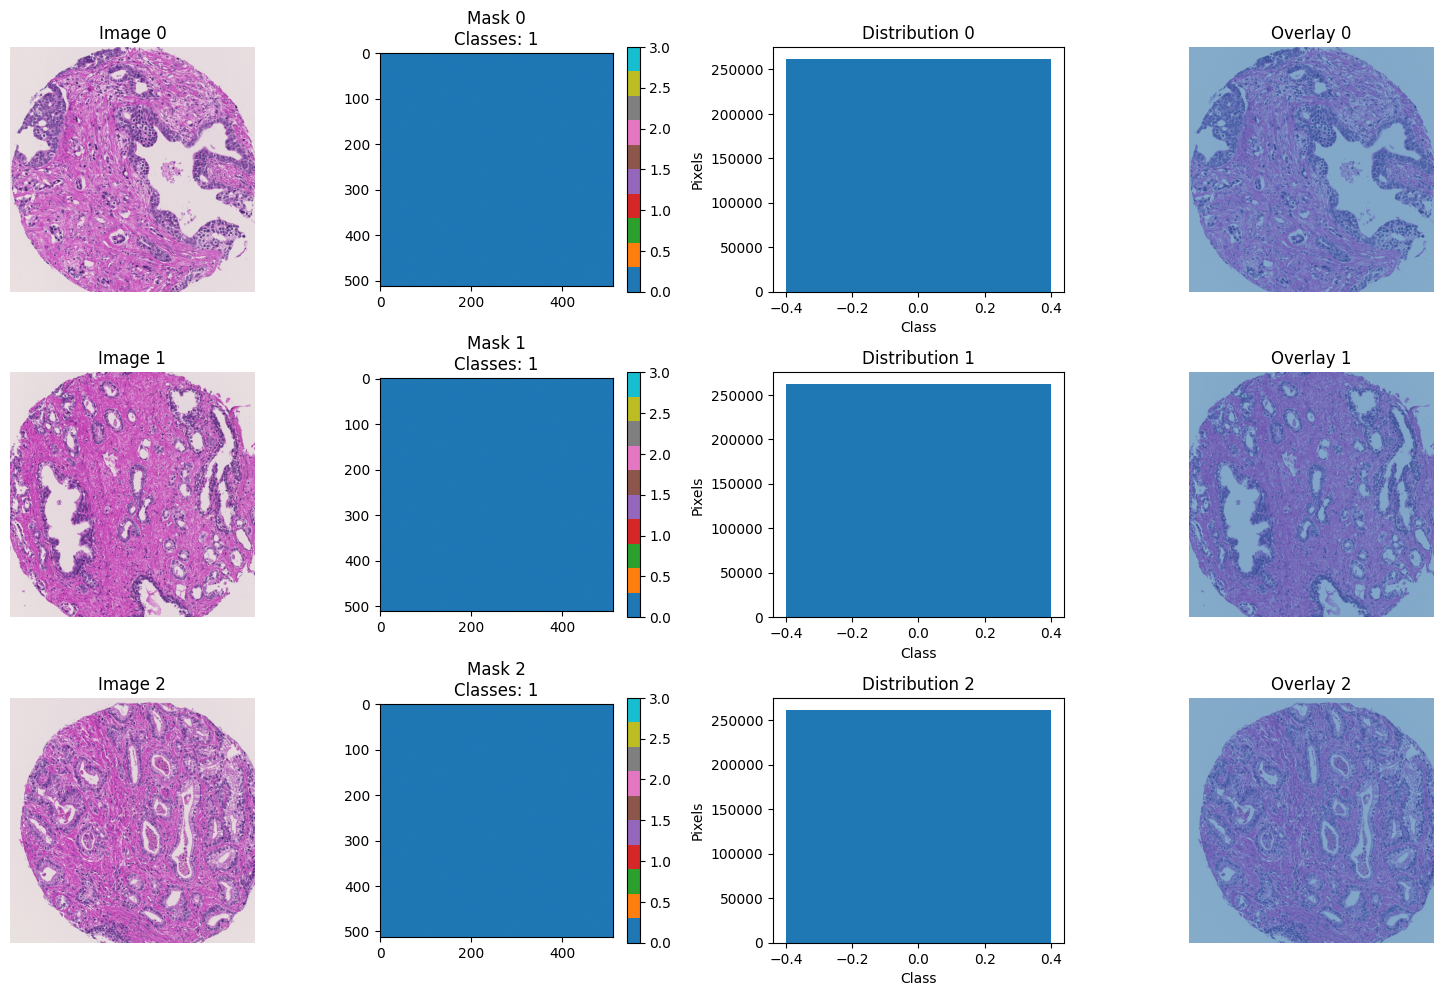


❌ STILL FAILED! Only found classes: [0]
   Need further debugging...


In [9]:
# FIXED LOADING FUNCTION - Bug düzeltmesi
import tensorflow as tf
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_images_and_masks_FIXED(image_dir, mask_dir):
    """FIXED: Load and preprocess with proper value mapping"""
    images = []
    masks = []

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

    # Value mapping
    value_mapping = {
        29: 0,   # Background
        76: 1,   # Prostate
        225: 2,  # Lesion
        255: 3   # Other
    }

    print(f"🔧 Processing {len(image_files)} files with mapping: {value_mapping}")

    for i, img_file in enumerate(image_files):
        if i % 100 == 0:
            print(f"  Processing {i}/{len(image_files)}...")

        # Load image
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"  ⚠️ Failed to load image: {img_file}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512))
        img = img.astype(np.float32) / 255.0

        # Load corresponding mask
        mask_file = img_file.replace('.jpg', '.png').replace('.jpeg', '.png')
        mask_path = os.path.join(mask_dir, mask_file)

        if os.path.exists(mask_path):
            # Load mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"  ⚠️ Failed to load mask: {mask_file}")
                continue

            # Resize with INTER_NEAREST to preserve values
            mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

            # CRITICAL: Apply value mapping correctly
            mapped_mask = np.zeros_like(mask, dtype=np.uint8)

            # Map each value
            for old_val, new_val in value_mapping.items():
                mapped_mask[mask == old_val] = new_val

            # Handle unmapped values (map to background)
            unique_original = np.unique(mask)
            for val in unique_original:
                if val not in value_mapping.keys():
                    mapped_mask[mask == val] = 0  # Map to background

            # DEBUG: Print mapping results for first few masks
            if i < 3:
                print(f"    📊 {mask_file}:")
                print(f"      Original unique: {np.unique(mask)}")
                print(f"      Mapped unique: {np.unique(mapped_mask)}")
                print(f"      Class distribution:")
                for cls in range(4):
                    count = np.sum(mapped_mask == cls)
                    pct = count / mapped_mask.size * 100
                    print(f"        Class {cls}: {count:,} pixels ({pct:.1f}%)")

            # Add to lists
            images.append(img)
            masks.append(mapped_mask)

        else:
            print(f"  ⚠️ Mask not found: {mask_file}")
            # Create background mask if not found
            empty_mask = np.zeros((512, 512), dtype=np.uint8)
            images.append(img)
            masks.append(empty_mask)

    # Convert to numpy arrays
    images_array = np.array(images)
    masks_array = np.array(masks)

    print(f"✅ Loading completed:")
    print(f"  Images shape: {images_array.shape}")
    print(f"  Masks shape: {masks_array.shape}")
    print(f"  Masks dtype: {masks_array.dtype}")
    print(f"  Final unique values in all masks: {np.unique(masks_array)}")

    # Final validation
    for cls in range(4):
        count = np.sum(masks_array == cls)
        pct = count / masks_array.size * 100
        print(f"  📊 Total Class {cls}: {count:,} pixels ({pct:.1f}%)")

    return images_array, masks_array

# CRITICAL: Re-load data with FIXED function
print("🔥 RE-LOADING DATA WITH FIXED FUNCTION...")
print("="*60)

# Paths
base_path = '/content/drive/MyDrive/prostate_data'
train_img_path = os.path.join(base_path, 'original_images/original_images')
train_mask_path = os.path.join(base_path, 'mask_images')
test_img_path = os.path.join(base_path, 'test_img_dir')
test_mask_path = os.path.join(base_path, 'test_mask_dir')

# Load with FIXED function
X_train_full, y_train_full = load_images_and_masks_FIXED(train_img_path, train_mask_path)

print(f"\n🎯 VALIDATION CHECK:")
print(f"  X_train_full shape: {X_train_full.shape}")
print(f"  y_train_full shape: {y_train_full.shape}")
print(f"  y_train_full unique: {np.unique(y_train_full)}")
print(f"  y_train_full dtype: {y_train_full.dtype}")

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"\n  After split:")
print(f"  y_train unique: {np.unique(y_train)}")
print(f"  y_val unique: {np.unique(y_val)}")

# Load test data if exists
if os.path.exists(test_img_path):
    X_test, y_test = load_images_and_masks_FIXED(test_img_path, test_mask_path)
    print(f"  y_test unique: {np.unique(y_test)}")
else:
    X_test, y_test = X_val, y_val
    print(f"  Using validation as test data")

# Visual validation
print(f"\n🎨 VISUAL VALIDATION:")
plt.figure(figsize=(15, 10))

for i in range(3):
    # Original image
    plt.subplot(3, 4, i*4 + 1)
    plt.imshow(X_train_full[i])
    plt.title(f"Image {i}")
    plt.axis('off')

    # Mask with different colormap
    plt.subplot(3, 4, i*4 + 2)
    plt.imshow(y_train_full[i], cmap='tab10', vmin=0, vmax=3)
    plt.title(f"Mask {i}\nClasses: {len(np.unique(y_train_full[i]))}")
    plt.colorbar()

    # Class distribution
    plt.subplot(3, 4, i*4 + 3)
    unique, counts = np.unique(y_train_full[i], return_counts=True)
    plt.bar(unique, counts)
    plt.title(f"Distribution {i}")
    plt.xlabel('Class')
    plt.ylabel('Pixels')

    # Overlay
    plt.subplot(3, 4, i*4 + 4)
    plt.imshow(X_train_full[i])
    plt.imshow(y_train_full[i], alpha=0.5, cmap='tab10', vmin=0, vmax=3)
    plt.title(f"Overlay {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Final check
if len(np.unique(y_train_full)) > 1:
    print(f"\n✅ SUCCESS! Multi-class data loaded correctly!")
    print(f"   Classes found: {np.unique(y_train_full)}")
    print(f"   Ready for training!")
else:
    print(f"\n❌ STILL FAILED! Only found classes: {np.unique(y_train_full)}")
    print(f"   Need further debugging...")